In [7]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter as gauss
# from scipy.integrate import trapezoid as trapz
from pyspec import spectrum as spec
from matplotlib.colors import LogNorm
import warnings
import scipy.signal as sig
import scipy.stats as stats
import sys
import seaborn as sns
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle


from dask.diagnostics import ProgressBar


import scipy.integrate as integ
warnings.filterwarnings("ignore")

In [8]:
def spec_ogive(spec,kr):
    
    Ogive_Kr=np.array(kr)
    # Middle Value Wavenumber position for plot
    Ogive_Krx=(Ogive_Kr[:-1]+Ogive_Kr[1:])/2
    # dK=np.diff(Ogive_Kr)[0]
    
    #Flipped Integration in wavenumber and then flipped again
    Ogive_inv=integ.cumtrapz(y=spec[::-1],x=Ogive_Kr[::-1]);
    Ogive_Spec=-Ogive_inv[::-1];


    return Ogive_Krx,Ogive_Spec


In [9]:

path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[1:],data_vars='minimal')

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[1:],data_vars='minimal')

In [10]:
dxx=0.5
dyy=dxx

In [71]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [12]:
import datetime

# t_ind=pd.DatetimeIndex(varf.time_counter.compute())
t_ind=varf.time_counter.groupby("time_counter.dayofyear").mean()
mon_ind=t_ind.dt.month
mes=np.array([12,1,2,3,4,5,6,7])
mes_str=['Dec/11','Jan/12','Feb/12','Mar/12','Apr/12','May/12','Jun/12','Jul/12']

# For Spectra

In [14]:
%%time
chunks_new={'dayofyear':40}


tf=varf.temp.groupby("time_counter.dayofyear").mean()
tf=tf.chunk(chunks=chunks_new);
tf=tf[:,100:-100,100:-200].compute();
tf=tf[:-1,1:-1,1:-1]


tf=varf.temp.groupby("time_counter.dayofyear").mean()
tf=tf.chunk(chunks=chunks_new);
tf=tf[:,100:-100,100:-200].compute();
tf=tf[:-1,1:-1,1:-1]




CPU times: user 49.2 s, sys: 1min 19s, total: 2min 8s
Wall time: 22.3 s


### Method Pyspec

In [17]:
TTf2=spec.TWODimensional_spec(tf[0],dxx,dyy,detrend=True)

### Method xrft

In [64]:
# nf=2
# wdws=None #'flattop','hann'
# wdw_cor=None
# scl='spectrum'

nf=2
wdws='hann' #'flattop','hann'
wdw_cor=True
scl='density'


with ProgressBar():
    TTf=xrft.isotropic_power_spectrum(tf[0].drop(['nav_lat_rho','nav_lon_rho']),
                                      dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

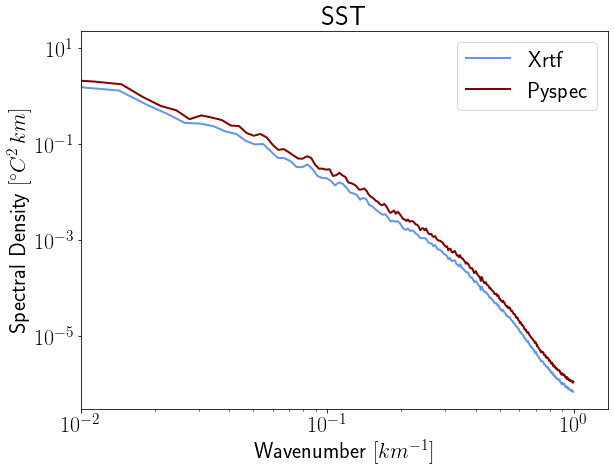

In [72]:
plt.figure(figsize=(9,7))


plt.plot(TTf.freq_r/dxx,TTf/dxx,label='Xrtf',linewidth=2,color='cornflowerblue')
plt.plot(TTf2.ki,TTf2.ispec,label='Pyspec',linewidth=2,color='maroon')


plt.legend()

plt.yscale('log')
plt.xscale('log')


plt.title('SST')
plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
plt.ylabel(r'Spectral Density $[^{\circ}C^{2}\,km]\,$',fontweight='bold')

plt.xlim(1/100,0)
# plt.ylim(1e-8,1e-1)
plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/Total_avg_SST.png')

# For Energy

In [201]:
uf=varf.u.groupby("time_counter.dayofyear").mean()
uf=uf.chunk(chunks=chunks_new);
uf=uf.compute();

vf=varf.v.groupby("time_counter.dayofyear").mean()
vf=vf.chunk(chunks=chunks_new);
vf=vf.compute();


In [202]:
uf,vf,_=romspickle.uvw2rho_3d(uf,vf,uf)
uf,vf=uf[:,100:-100,100:-200],vf[:,100:-100,100:-200]

ut,vt,_=romspickle.uvw2rho_3d(ut,vt,ut)
ut,vt=ut[:,100:-100,100:-200],vt[:,100:-100,100:-200]

### Method Pyspec

In [203]:
Uf2=spec.TWODimensional_spec(uf[0],dxx*1e3,dyy*1e3,detrend=True) # in meters
Vf2=spec.TWODimensional_spec(vf[0],dxx*1e3,dyy*1e3,detrend=True)

In [204]:
EKEf2= 0.5*(Uf2.ispec+Vf2.ispec)
Ki2=Uf2.ki

### Method xrft

In [205]:
nf=1
wdws='hann' #'flattop','hann'
wdw_cor=True
scl='density'

# nf=2
# wdws=None #'flattop','hann'
# wdw_cor=None
# scl='spectrum'


with ProgressBar():
    Uf=xrft.isotropic_power_spectrum(uf[0].drop(['dayofyear']),
                                      dim=['y_u','x_u'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    
    Vf=xrft.isotropic_power_spectrum(vf[0].drop(['dayofyear']),
                                  dim=['y_v','x_v'],
                          nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                 window=wdws,window_correction=wdw_cor)

In [206]:
EKEf=0.5*(Uf.data+Vf.data)
Ki=Uf.freq_r

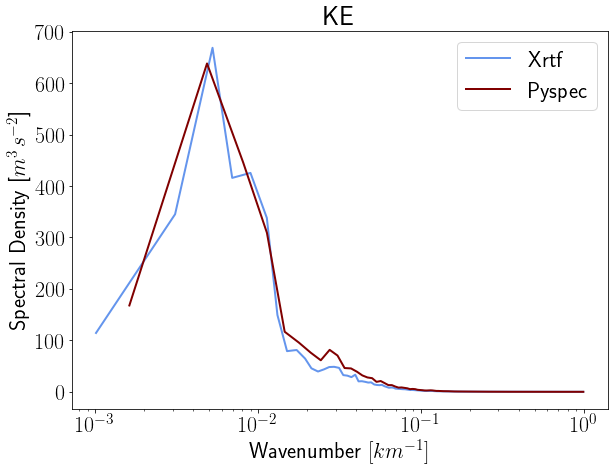

In [207]:
plt.figure(figsize=(9,7))


plt.plot(Ki/(dxx),EKEf/(dxx)*(1e3),label='Xrtf',linewidth=2,color='cornflowerblue')
plt.plot(Ki2*1e3,EKEf2,label='Pyspec',linewidth=2,color='maroon')


plt.legend()

# plt.yscale('log')
plt.xscale('log')


plt.title('KE')
plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
plt.ylabel(r'Spectral Density [$m^3\,s^{-2}$]',fontweight='bold')


# plt.xlim(1/100,0)
# plt.xlim(7e-2,0)


# plt.ylim(0,100)
plt.tight_layout()

# For Co-Spectra

In [208]:
#loading stress
usf=varf.sustr.groupby("time_counter.dayofyear").mean()
usf=usf.chunk(chunks=chunks_new);
usf=usf.compute();

vsf=varf.svstr.groupby("time_counter.dayofyear").mean()
vsf=vsf.chunk(chunks=chunks_new);
vsf=vsf.compute();


In [209]:
usf,vsf,_=romspickle.uvw2rho_3d(usf,vsf,usf)
usf,vsf=usf[:,100:-100,100:-200],vsf[:,100:-100,100:-200]


### Pyspec

In [210]:
Xf2=spec.CO_TWODimensional_spec(usf[0],uf[0],dxx*1e3,dyy*1e3,detrend=True)
Yf2=spec.CO_TWODimensional_spec(vsf[0],vf[0],dxx*1e3,dyy*1e3,detrend=True)

In [211]:
WWf2=(1/1024)*(Xf2.ispec + Yf2.ispec)
Ki2=Xf2.ki

### Xrft

In [212]:
nfw=1
wdws='hann' #'flattop','hann'
wdw_cor=True
scl='density'

with ProgressBar():
    Xf=xrft.isotropic_cross_spectrum(usf[0],uf[0],
                                      dim=['y_u','x_u'],nfactor=nfw,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real

    Yf=xrft.isotropic_cross_spectrum(vsf[0],vf[0],
                                      dim=['y_v','x_v'],nfactor=nfw,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real

In [213]:
WWf=(1/1024)*(Xf.data + Yf.data)
Ki=Xf.freq_r

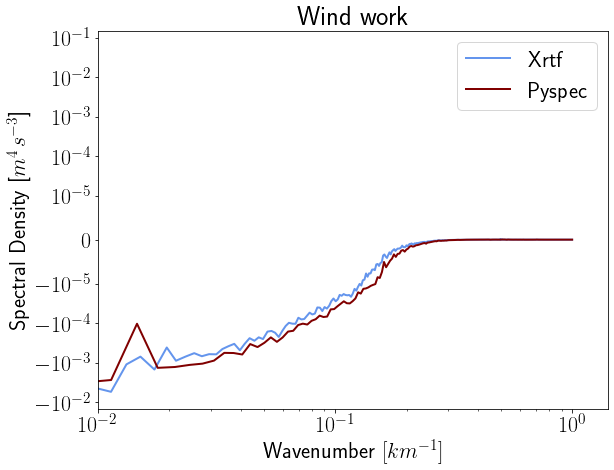

In [214]:
plt.figure(figsize=(9,7))


plt.plot(Ki/dxx,(WWf/dxx)*(1e3),label='Xrtf',linewidth=2,color='cornflowerblue')
plt.plot(Ki2*(1e3),WWf2,label='Pyspec',linewidth=2,color='maroon')


plt.legend()

plt.yscale('symlog',linthresh=1e-5)
plt.xscale('log')


plt.title('Wind work')
plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
plt.ylabel(r'Spectral Density [$m^4\,s^{-3}$]',fontweight='bold')


plt.xlim(1/100,0)
# plt.ylim(1e-8,1e-1)
plt.tight_layout()

# Conclusion

## Pyspec
#### Uses window correction and spectral density;
#### Hanning window is used
#### Easy to compute different dx's

## xrft
#### correction is /dxx for both frequency and spectrum
#### for resolution from km to m is times 1000, not divided
#### Different window choice changes the value